# Classification Model Building of the 102-Flower Dataset

In this notebook, a pre-trained ResNet50 model will be utilized to classify flowers across 102 classes. The Transfer Learning approach that has been explored involves feature extraction and the replacement of the fully connected model on top of the ResNet.

The following considerations have been taken into account:

- **Score Metric:** Accuracy will be used as the evaluation metric to facilitate comparison with results from other publications, such as reference [5], which achieved an accuracy of 97.9% using a ResNet architecture.
- **Data Split:** While the data already includes train, validation, and test splits, I have chosen to create new stratified splits with a distribution of 60% for training, 20% for validation, and 20% for testing.
- **Regularization:** Dropout has been considered as one of the regularization hyperparameters to mitigate overfitting. The number of units in the fully connected layers has also been subject to evaluation.
- **Optimizer and learning rate:** Stochastic Gradient Descent (SGD), a widely used optimizer, has been selected for simplicity and its learning rate has been considered one hyper-parameter to optimize.
- **Augmentation:** Data augmentation techniques have been explored to address overfitting. A limited set of image augmentation techniques have been employed, with the option to enable or disable them during training.
- **Layers used to extract features:** As suggested in [2], feature extraction will be employed instead of fine-tuning since the dataset is small, with fewer than 1000 images per class, making fine-tuning prone to overfitting, and the choice between deep-level and lower-level layers depends on the dataset's similarity to the original.

In [2]:
# To mount Google Drive
from google.colab import drive

# Mount local Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pandas opencv-python scikit-learn mat4py matplotlib tqdm keras-tuner

In [4]:
# Standard Library imports
from pathlib import Path
import random
import os
import argparse
import pickle
import multiprocessing
import gc
from pprint import pprint


# External imports
import numpy as np
import matplotlib.pyplot as plt
from mat4py import loadmat
import cv2
import pandas as pd
import tensorflow as tf
from tensorflow.data import AUTOTUNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
import h5py
import keras_tuner
from tqdm.notebook import tqdm


# Pandas display options
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_colwidth", None)


# Create a folder and parants in the root directory
!mkdir -p "/content/drive/My Drive/DATASETS/102flowers"

# Change into project directory
%cd "/content/drive/My Drive/DATASETS/102flowers"

# Download data if it doesn't already exist
!wget https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz -nc --output-document 102flowers.tgz
!wget https://thor.robots.ox.ac.uk/datasets/flowers-102/imagelabels.mat -nc --output-document imagelabels.mat

# Extract flowers data if they don't exist already
# !tar --skip-old-files -xzf 102flowers.tgz

Using TensorFlow backend
/content/drive/My Drive/DATASETS/102flowers
File ‘102flowers.tgz’ already there; not retrieving.
File ‘imagelabels.mat’ already there; not retrieving.


In [5]:
BASE_PATH = Path("/content/drive/My Drive/DATASETS/102flowers")

IMAGES_PATH = str(BASE_PATH / Path("jpg"))
IMAGE_LABELS_PATH = str(BASE_PATH / Path("imagelabels.mat"))

HYPER_SEARCH_PATH = str(BASE_PATH / Path("hyper_search"))

BATCH_SIZE = 32
IM_SIZE = 224
EPOCHS = 25
TOTAL_CLASSES = 102

In [6]:
def list_files(dirpath):
    base_directory = Path(dirpath)
    for child in base_directory.rglob('*.jpg'):
        if child.is_file():
            yield str(child.absolute())

In [7]:
def plot_training(history, plotPath):
    fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")

    num_epochs = len(history.history["accuracy"])

    ax1.plot(np.arange(0, num_epochs), history.history["accuracy"], label="train_acc")
    ax1.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="val_acc")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="lower right")

    ax2.plot(np.arange(0, num_epochs), history.history["loss"], label="train_loss")
    ax2.plot(np.arange(0, num_epochs), history.history["val_loss"], label="val_loss")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="lower left")

    plt.savefig(plotPath)

In [8]:
images_paths = list(list_files(IMAGES_PATH))
images_paths.sort()

image_labels = loadmat(IMAGE_LABELS_PATH)
image_labels = [str(x) for x in image_labels['labels']]

# Prepare training, validation and test data splits

train_files, test_files, train_labels, test_labels = train_test_split(
    images_paths, image_labels, test_size=0.4, random_state=42, stratify=image_labels
)

validation_files, test_files, validation_labels, test_labels = train_test_split(
    test_files, test_labels, test_size=0.5, random_state=42, stratify=test_labels
)

print('Training length:', len(train_files))
print('Validation length:', len(validation_files))
print('Test length:', len(test_files))

Training length: 4913
Validation length: 1638
Test length: 1638


Load the ResNet50 model without the fully connected layers:

In [9]:
# Load the ResNet50 network without the fully connected layers
resnet_model = tf.keras.applications.resnet50.ResNet50(
    weights="imagenet",
    include_top=False,
    input_tensor=tf.keras.Input(shape=(IM_SIZE, IM_SIZE, 3))
)

94765736/94765736 [==============================] - 6s 0us/step


Create a function to build a model with specific hyperparameters:

In [10]:
def build_model(truncated_model, units, dropout, learning_rate):

    head_model = truncated_model.output
    head_model = tf.keras.layers.Flatten(name="flatten")(head_model)
    head_model = tf.keras.layers.Dense(units=units[0], activation="relu")(head_model)
    head_model = tf.keras.layers.Dropout(rate=dropout)(head_model)
    head_model = tf.keras.layers.Dense(units=units[1], activation="relu")(head_model)
    head_model = tf.keras.layers.Dense(TOTAL_CLASSES, activation="softmax")(head_model)

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model = tf.keras.models.Model(inputs=truncated_model.input, outputs=head_model)

    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )

    return model

Let's create functions to generate batches of images. The actions performed will be:
- Image loading and decoding from jpeg
- Image resizing to have a size of 224 x 224
- Preprocessing of the images according (mean subtraction and channel reordering)
- Possible train data augmentation
- One-Hot encoding of the labels
- Cache, batching, prefetching and repeating of images to have a fast and continuous source of images

In [11]:
def load_image(im_path, label):
    image = tf.io.read_file(im_path)

    # Return values have type uint8
    image = tf.image.decode_jpeg(image, channels=3)

    # Return value has type float32, unless the method is ResizeMethod.NEAREST_NEIGHBOR
    image = tf.image.resize(image, (IM_SIZE, IM_SIZE), method=tf.image.ResizeMethod.BILINEAR)

    return (image, label)


def preprocess_image(images, labels):
    # Proces image in "caffe" style.
    # Convert the images from RGB to BGR, then zero-center each
    # color channel with respect to the ImageNet dataset, without scaling.
    # The returned image will preserve the original image type (int or float)
    return tf.keras.applications.resnet50.preprocess_input(images), labels


def augment_using_layers(images, labels, sequential_augmenter):
    return (sequential_augmenter(images), labels)


# Train set data augmentation actions
train_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.125)  # fraction of 2pi
])

# No data augmentation actions should be done for validation or testing
test_aug = tf.keras.Sequential([
    # load_image already loaded the image with floating point type
])

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
train_labels_encoded = encoder.fit_transform(np.array(train_labels).reshape(-1, 1))
validation_labels_encoded = encoder.transform(np.array(validation_labels).reshape(-1, 1))


def generate_dataset(files, labels, aug=None, preprocess=True):
    DS = tf.data.Dataset.from_tensor_slices((files, labels))
    DS = DS.shuffle(len(files))
    DS = DS.map(load_image, num_parallel_calls=AUTOTUNE)

    if preprocess:
        DS = DS.map(preprocess_image, num_parallel_calls=AUTOTUNE)

    if aug is not None:
        DS = DS.map(lambda x, y: augment_using_layers(x, y, aug), num_parallel_calls=AUTOTUNE)

    DS = DS.cache()
    DS = DS.repeat()
    DS = DS.batch(BATCH_SIZE)
    DS = DS.prefetch(AUTOTUNE)

    return DS

In [12]:
trainDS = generate_dataset(train_files, train_labels_encoded)
validationDS = generate_dataset(validation_files, validation_labels_encoded)

Create a function for Keras Tuner where the hyperparameter search space is defined, and search for a base set of hyperparameters to use:

In [18]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)


def build_hyp_model(hp, truncated_model):
    """
    Create a model where the model hyper-parameters are defined as Keras Tuner
    objects, which define a search range where to sample hyper-parameters.

    PARAMETERS
    ----------
    hp: a Keras Tuner hyperparameter object
    """

    units = [
        hp.Int("units_l1", min_value=32, max_value=512, step=64),
        hp.Int("units_l2", min_value=16, max_value=512, step=64)
    ]

    dropout = hp.Float(
        'dropout', min_value=0.0, max_value=0.5, step=0.1
    )

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-3, sampling="log")

    return build_model(truncated_model, units, dropout, learning_rate)


def get_best_model_hyperparameters(project_name, tuner="hyperband"):
    """
    Given the name of a previously Keras-Tuner saved project, get the best
    hyper-parameters.
    """

    if tuner == "hyperband":

        tuner = keras_tuner.Hyperband(
            lambda hp: build_hyp_model(hp, resnet_model),
            objective='val_accuracy',
            max_epochs=15,
            factor=3,
            directory=HYPER_SEARCH_PATH,
            hyperband_iterations=1,
            project_name=project_name,
            overwrite=False,
        )
    elif tuner == "bayesian":
        tuner = keras_tuner.BayesianOptimization (
            hypermodel=lambda hp: build_hyp_model(hp, truncated_model),
            objective='val_accuracy',
            max_trials=20,
            directory=HYPER_SEARCH_PATH,
            project_name=f'transfer_learning_feature_extraction_aug_{augment}_{layer_name}',
            overwrite=False,
        )

    return  tuner.get_best_hyperparameters(1)


def get_best_model_history(project_name, tuner="hyperband"):
    """
    Given the name of a previously Keras-Tuner saved project, get the best
    hyper-parameters found, train a model and return the model training history.
    """

    hyperparameters = get_best_model_hyperparameters(project_name, tuner)

    if len(hyperparameters) == 0:
        return None, None

    hyperparameters = hyperparameters[0].values

    best_model = build_model(
        resnet_model,
        [hyperparameters["units_l1"], hyperparameters["units_l2"]],
        hyperparameters["dropout"],
        hyperparameters["lr"]
    )

    history = best_model.fit(
        x=trainDS,
        steps_per_epoch=len(train_files) // BATCH_SIZE,
        validation_data=validationDS,
        validation_steps=len(validation_files) // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stop],
        verbose=0
    )

    return history, hyperparameters

In [ ]:
tuner = keras_tuner.Hyperband(
    lambda hp: build_hyp_model(hp, resnet_model),
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    directory=HYPER_SEARCH_PATH,
    hyperband_iterations=1,
    project_name=f'transfer_learning_feature_extraction_base_no_aug',
    overwrite=False,
)

tuner.search(
    x=trainDS,
    steps_per_epoch = len(train_files) // BATCH_SIZE,
    validation_data = validationDS,
    validation_steps = len(validation_files) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

tuner.results_summary(num_trials=1)

Reloading Tuner from /content/drive/My Drive/DATASETS/102flowers/hyper_search/transfer_learning_feature_extraction_base_no_aug/tuner0.json
{'dropout': 0.2,
 'lr': 0.0004431235881905902,
 'tuner/bracket': 2,
 'tuner/epochs': 15,
 'tuner/initial_epoch': 5,
 'tuner/round': 2,
 'tuner/trial_id': '0012',
 'units_l1': 352,
 'units_l2': 144}
Train accuracy: 0.99918; Validation accuracy: 0.86523


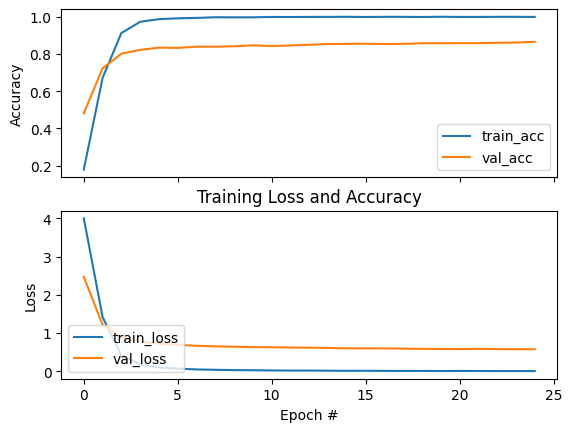

In [ ]:
# Recover best hyperparameters, train a model and get the training history
project_name = "transfer_learning_feature_extraction_base_no_aug"
history, best_hyperparameters = get_best_model_history(project_name)

# Print best hyper parameters
pprint(best_hyperparameters)

# Show training plot
plot_training(history, "training_plot_base_no_aug.png")

# Print best scores
train_score = history.history["accuracy"][-1]
val_score = history.history["val_accuracy"][-1]
print(f"Train accuracy: {train_score:.5f}; Validation accuracy: {val_score:.5f}")

The search found a set of hyperparameters that achieved a validation accuracy just above 0.8. These hyperparameters are specific to the experiment's configuration, which excludes data augmentation and utilizes all convolution layers.

However, the training plot reveals clear overfitting in the fully connected network model, which was trained using features extracted from the original ResNet50 model.

To address overfitting, we can employ several regularization techniques, including:

- Dropout
- Data augmentation
- Feature extraction using lower-level network layers.

Now, let's inspect the layers of the headless ResNet50 model:

In [ ]:
# Inspection of the layers
for (i, layer) in enumerate(resnet_model.layers):
    print(f"{i}\t{layer.name}\t{layer.__class__.__name__}")

0	input_1	InputLayer
1	conv1_pad	ZeroPadding2D
2	conv1_conv	Conv2D
3	conv1_bn	BatchNormalization
4	conv1_relu	Activation
5	pool1_pad	ZeroPadding2D
6	pool1_pool	MaxPooling2D
7	conv2_block1_1_conv	Conv2D
8	conv2_block1_1_bn	BatchNormalization
9	conv2_block1_1_relu	Activation
10	conv2_block1_2_conv	Conv2D
11	conv2_block1_2_bn	BatchNormalization
12	conv2_block1_2_relu	Activation
13	conv2_block1_0_conv	Conv2D
14	conv2_block1_3_conv	Conv2D
15	conv2_block1_0_bn	BatchNormalization
16	conv2_block1_3_bn	BatchNormalization
17	conv2_block1_add	Add
18	conv2_block1_out	Activation
19	conv2_block2_1_conv	Conv2D
20	conv2_block2_1_bn	BatchNormalization
21	conv2_block2_1_relu	Activation
22	conv2_block2_2_conv	Conv2D
23	conv2_block2_2_bn	BatchNormalization
24	conv2_block2_2_relu	Activation
25	conv2_block2_3_conv	Conv2D
26	conv2_block2_3_bn	BatchNormalization
27	conv2_block2_add	Add
28	conv2_block2_out	Activation
29	conv2_block3_1_conv	Conv2D
30	conv2_block3_1_bn	BatchNormalization
31	conv2_block3_1_relu	A

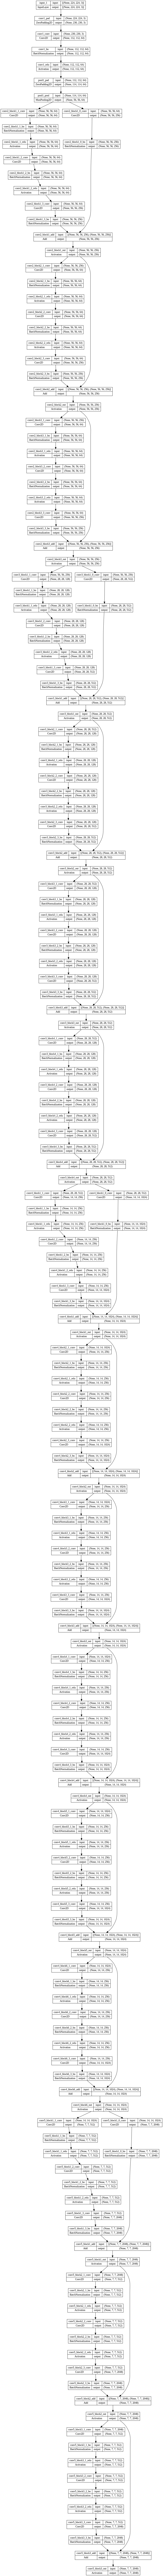

In [ ]:
tf.keras.utils.plot_model(resnet_model, "full_resnet_no_fc_layer.png", show_shapes=True)

The network consists of 174 layers divided into 5 blocks, each named 'convN_...'. The network will be truncated at the last 'Activation' layer of each of blocks 2, 3, and 4, with the hope that these more general features will enhance generalization.

Several key hyperparameters require tuning, including:

- Learning rate
- Number of units per layer
- Dropout (for regularization)

In addition, we need to determine which early layers to use for feature extraction and assess various data augmentation techniques.


Let's take a look at how the augmented images appear to ensure that there are no issues related to the applied transformations:

Image shape:  (224, 224, 3) ; image type:  float32
Received image min-max: -119.07 - 138.22


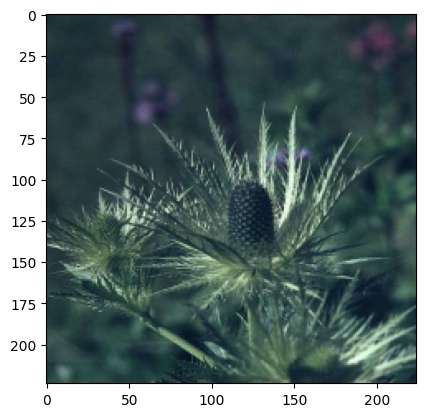

In [ ]:
def display(ds, preprocessed=True):
    """
    Display one dataset image
    """

    # Get one image from the dataset
    images, _ = next(iter(ds.take(1)))
    image = images[0].numpy()

    print(f"Image shape: ", image.shape, "; image type: ", image.dtype)
    print(f"Received image min-max: {image.min():.2f} - {image.max():.2f}")

    # BGR -> RGB. This assumes that the image was preprocessed with
    # tf.keras.applications.resnet50.preprocess_input
    # which changes the channel order from RGB to BGR
    if preprocessed:
        image = image[..., ::-1]

    # Rescale to some range around -1, 1
    image /= 255.0

    # Rescale to 0-1 range
    image = (image - image.min()) / (image.max()- image.min())

    plt.imshow(image)

display(trainDS, preprocessed=True)

To investigate how features from earlier layers impact the model's performance, and the effects of data augmentation, we will search for the best model by progressively utilizing lower-level layers and turning on and off data augmentation.

The procedure will be as follows:

- Truncate the ResNet50 network and use the output of Activation blocks at different depths.
- Extract features from each level using **no** data augmentation
- Extract features from each level using data augmentation
- Search for the best hyperparameters for these features with and without data augmentation.

We will then compare the best results achieved by using features with varying levels of specificity to the original dataset on which they were trained.

In [ ]:
# The indexes of the last layers of the intermediate blocks that form ResNet50
# E.g. the last layer (Activation) of the block "conv2" has index 38
layers_info = [
    {"name" : "conv5", "layer_idx": 174, "n_features": 7 * 7 * 2048},
    {"name" : "conv4", "layer_idx": 142, "n_features": 14 * 14 * 1024},
    {"name" : "conv3", "layer_idx": 80,  "n_features": 28 * 28 * 512},
    {"name" : "conv2", "layer_idx": 38,  "n_features": 56 * 56 * 256},
]

for layer_info in layers_info:
    layer_name  = layer_info["name"]
    layer_index = layer_info["layer_idx"]
    n_features  = layer_info["n_features"]

    print(f"Extracting features using layer '{layer_name}'")

    # Model for feature extraction
    truncated_model = tf.keras.models.Model(
        inputs=resnet_model.layers[0].input,
        outputs=resnet_model.layers[layer_index].output
    )

    # Freeze the feature extraction layers, as only the fully connected layers
    # will be trained for now
    for layer in truncated_model.layers:
        layer.trainable = False


    for augment in [False, True]:

        if not augment:
            train_aug = None
            test_aug = None

        trainDS = generate_dataset(train_files, train_labels_encoded, train_aug)
        validationDS = generate_dataset(validation_files, validation_labels_encoded, test_aug)

        ########################################################################
        # Search for good hyper-parameters
        ########################################################################

        tuner = keras_tuner.BayesianOptimization (
            hypermodel=lambda hp: build_hyp_model(hp, truncated_model),
            objective='val_accuracy',
            max_trials=20,
            directory=HYPER_SEARCH_PATH,
            project_name=f'transfer_learning_feature_extraction_aug_{augment}_{layer_name}',
            overwrite=False,
        )

        tuner.search(
            x=trainDS,
            steps_per_epoch = len(train_files) // BATCH_SIZE,
            validation_data = validationDS,
            validation_steps = len(validation_files) // BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=[early_stop]
        )

        gc.collect()

    print()

Now, let's retrieve the stored hyperparameters data and utilize the information from the best hyperparameters to construct the optimal models for each layer and data augmentation combination:

In [24]:
# To store the results across loops
results = {
    "train_score": [],
    "val_score": [],
    "conv_layer": [],
    "augmentation": [],
    "dropout": [],
    "units_l1": [],
    "units_l2": [],
    "lr": [],
}

for layer_info in layers_info:
    layer_name  = layer_info["name"]
    for augment in [False, True]:

        # Train a model with the best found hyper-parameters
        project_name = f'transfer_learning_feature_extraction_aug_{augment}_{layer_name}'
        history, hyperparameters = get_best_model_history(project_name, "bayesian")

        if history is None:
            continue

        # Store the results
        train_score = history.history["accuracy"][-1]
        val_score = history.history["val_accuracy"][-1]

        results["train_score"].append(train_score)
        results["val_score"].append(val_score)
        results["conv_layer"].append(layer_name)
        results["augmentation"].append(augment)
        results["dropout"].append(hyperparameters["dropout"])
        results["units_l1"].append(hyperparameters["units_l1"])
        results["units_l2"].append(hyperparameters["units_l2"])
        results["lr"].append(hyperparameters["lr"])

        print(f"Augmented: {augment} - Training score: {train_score:.5f}; validation score: {val_score:.5f}")

results_df = pd.DataFrame(results)
results_df.to_csv("results.csv")

Reloading Tuner from /content/drive/My Drive/DATASETS/102flowers/hyper_search/transfer_learning_feature_extraction_aug_False_conv5/tuner0.json
Augmented: False - Training score: 0.99959; validation score: 0.89400
Reloading Tuner from /content/drive/My Drive/DATASETS/102flowers/hyper_search/transfer_learning_feature_extraction_aug_True_conv5/tuner0.json
Augmented: True - Training score: 0.99959; validation score: 0.90993
Reloading Tuner from /content/drive/My Drive/DATASETS/102flowers/hyper_search/transfer_learning_feature_extraction_aug_False_conv4/tuner0.json
Augmented: False - Training score: 0.99939; validation score: 0.90257
Reloading Tuner from /content/drive/My Drive/DATASETS/102flowers/hyper_search/transfer_learning_feature_extraction_aug_True_conv4/tuner0.json
Augmented: True - Training score: 0.99857; validation score: 0.90441
Reloading Tuner from /content/drive/My Drive/DATASETS/102flowers/hyper_search/transfer_learning_feature_extraction_aug_False_conv3/tuner0.json
Augmented

In [26]:
results_df = pd.DataFrame(results)
results_df.to_csv("results.csv")
results_df

,train_score,val_score,conv_layer,augmentation,dropout,units_l1,units_l2,lr
0,0.999592,0.893995,conv5,False,0.0,352,400,0.000856
1,0.999592,0.909926,conv5,True,0.1,288,464,0.000882
2,0.999387,0.902574,conv4,False,0.1,480,464,0.000408
3,0.998570,0.904412,conv4,True,0.4,480,464,0.000376
4,0.999183,0.857230,conv3,False,0.2,480,80,0.000151


Even though these results are not conclusive, they can provide some preliminary insights:

- Utilizing lower-level layers for feature extraction does not appear to enhance validation scores; in fact, it seems to deteriorate them further.

- It is inconclusive whether the utilization of the selected data augmentation techniques helps reduce overfitting. The results in the table above show that a slight improvement in generalization capability was achieved when using data augmentation. Exploring various additional augmentation techniques is advisable.

- The choice of hyperparameters appears to be influenced by the network's layer configuration and the employed data augmentation techniques. This influence is evident in the table above, where tests with different layers' depths showed variations in the numbers of units, learning rates, and dropout rates.

To report the final score obtained, a final model will be trained, using all the layers of the ResNet50 model, without data augmentation:

In [ ]:
project_name = 'transfer_learning_feature_extraction_aug_False_conv5'
hyperparameters = get_best_model_hyperparameters(project_name, tuner="bayesian")

if len(hyperparameters) > 0:

    hyperparameters = hyperparameters[0].values

    best_model = build_model(
        resnet_model,
        [hyperparameters["units_l1"], hyperparameters["units_l2"]],
        hyperparameters["dropout"],
        hyperparameters["lr"]
    )

    history = best_model.fit(
        x=trainDS,
        steps_per_epoch=len(train_files) // BATCH_SIZE,
        validation_data=validationDS,
        validation_steps=len(validation_files) // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stop],
        verbose=0
    )


Reloading Tuner from /content/drive/My Drive/DATASETS/102flowers/hyper_search/transfer_learning_feature_extraction_aug_True_conv5/tuner0.json


Evaluate the predictive performance of the model on the hold-out data:

In [ ]:
test_labels_encoded = encoder.transform(np.array(test_labels).reshape(-1, 1))
testDS = generate_dataset(test_files, test_labels_encoded)
loss, score = best_model.evaluate(testDS, steps=len(test_files)//BATCH_SIZE)
print(f"Accuracy score: {score: .5f}")

12/12 [==============================] - 31s 3s/step - loss: 0.4648 - accuracy: 0.8809
Accuracy score:  0.88086


## Conclusions

- Utilizing features from lower levels of the ResNet50 network proved ineffective in reducing observed overfitting; in fact, it exacerbated the issue.

- The data augmentation techniques could be effective in mitigating model overfitting, albeit to a limited extent in the current configuration. Different techniques should be explored.

- The accuracy score, evaluated on the test set, is indicative of the model's predictive performance. In comparison with the findings in [5], there is significant room for improvement in terms of overfitting reduction.

Possible actions to consider:

- Exploring the final results in a per-class basis.
- Incorporate mean subtraction based on the new train set mean.
- Address class imbalance by assigning weights.
- Transfer Learning by fine tuning convolutional layers

## References
- [1] Deep Learning for Computer Vision with Python - Starter bundle
- [2] Deep Learning for Computer Vision with Python - Practitioner Bundle
- [3] https://paperswithcode.com/sota/image-classification-on-flowers-102
- [4] https://neptune.ai/blog/transfer-learning-guide-examples-for-images-and-text-in-keras
- [5] https://paperswithcode.com/paper/resnet-strikes-back-an-improved-training